In [2]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split

In [51]:
def print_column_statistics(file_path):
    df = pd.read_csv(file_path)
    if 'date' in df.columns:
        df = df.drop(columns=['date'])
    stats = df.describe().loc[['mean', 'std', 'min', 'max']]
    for column in stats.columns:
        print(f"Column: {column}")
        print(f"Mean: {stats.loc['mean', column]}")
        print(f"Standard Deviation: {stats.loc['std', column]}")
        print(f"Minimum: {stats.loc['min', column]}")
        print(f"Maximum: {stats.loc['max', column]}")
        print("-" * 40)
    return stats
print_column_statistics('/kaggle/input/electricity/ETTm1.csv')

Column: HUFL
Mean: 7.413993338750831
Standard Deviation: 7.082928007664722
Minimum: -23.242000579833984
Maximum: 24.18000030517578
----------------------------------------
Column: HULL
Mean: 2.26141838280807
Standard Deviation: 2.041293332533788
Minimum: -5.692999839782715
Maximum: 10.3149995803833
----------------------------------------
Column: MUFL
Mean: 4.322226455704824
Standard Deviation: 6.829188917796115
Minimum: -26.367000579833984
Maximum: 18.08699989318848
----------------------------------------
Column: MULL
Mean: 0.8965089415929288
Standard Deviation: 1.8072392887434283
Minimum: -6.040999889373777
Maximum: 7.853000164031982
----------------------------------------
Column: LUFL
Mean: 3.0828884045137936
Standard Deviation: 1.1740630852195901
Minimum: -1.187999963760376
Maximum: 8.498000144958496
----------------------------------------
Column: LULL
Mean: 0.857907461289217
Standard Deviation: 0.6004401810633164
Minimum: -1.371000051498413
Maximum: 3.0460000038146973
---------

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
mean,7.413993,2.261418,4.322226,0.896509,3.082888,0.857907,13.320642
std,7.082928,2.041293,6.829189,1.807239,1.174063,0.600440,8.564817
min,-23.242001,-5.693000,-26.367001,-6.041000,-1.188000,-1.371000,-4.221000
max,24.180000,10.315000,18.087000,7.853000,8.498000,3.046000,46.007000


In [3]:
def preprocess(file_path, column_names, input_size, output_size, skip, scale = False):
    df = pd.read_csv(file_path)
    data = df[column_names].values
    scaler = StandardScaler()
    if scale:
        normalized = scaler.fit_transform(data)
    else:
        normalized = data

    inputs = []
    outputs = []

    for i in range(normalized.shape[1]):
        col_data = normalized[:, i] 
        for j in range(0, len(col_data) - input_size - output_size + 1, skip):
            input_window = col_data[j:j + input_size]
            output_window = col_data[j + input_size:j + input_size + output_size]
            inputs.append(input_window)
            outputs.append(output_window)

    inputs = np.array(inputs)
    outputs = np.array(outputs)
    
    return inputs, outputs

In [5]:
def get_real(signal):
    frequency_domain = np.fft.fft(signal, axis=1)
    real_parts = frequency_domain.real
    return real_parts

def get_imaginary(signal):
    frequency_domain = np.fft.fft(signal, axis=1)
    imaginary_parts = frequency_domain.imag
    return imaginary_parts

def get_amplitudes(signal):
    frequency_domain = np.fft.fft(signal, axis=1)
    magnitude = np.abs(frequency_domain)
    return magnitude

def get_phases(signal):
    frequency_domain = np.fft.fft(signal, axis=1)
    phase = np.angle(frequency_domain)
    return phase

def apply_transform(signal):
    frequency_domain = np.fft.fft(signal, axis=1)
    real_part = frequency_domain.real
    imag_part = frequency_domain.imag
    combined = np.concatenate((real_part, imag_part), axis=1)
    return combined

def apply_inverse(combined):
    half_size = combined.shape[1] // 2
    real_part = combined[:, :half_size]
    imag_part = combined[:, half_size:]
    complex_signal = real_part + 1j * imag_part
    time_domain_signal = np.fft.ifft(complex_signal, axis=1)
    return time_domain_signal.real

Clustering
Cluster 0: Purity = 0.3279, Number of Elements = 12221
Cluster 1: Purity = 0.6868, Number of Elements = 961
Cluster 2: Purity = 0.4366, Number of Elements = 4182
Cluster 3: Purity = 0.2758, Number of Elements = 10268
Total Purity: 0.3375

Clustering
Cluster 0: Purity = 0.2943, Number of Elements = 11707
Cluster 1: Purity = 0.3520, Number of Elements = 10788
Cluster 2: Purity = 0.6034, Number of Elements = 1170
Cluster 3: Purity = 0.3993, Number of Elements = 3967
Total Purity: 0.3450

Clustering
Cluster 0: Purity = 0.2811, Number of Elements = 8619
Cluster 1: Purity = 0.3582, Number of Elements = 13307
Cluster 2: Purity = 0.4055, Number of Elements = 2631
Cluster 3: Purity = 0.3925, Number of Elements = 3075
Total Purity: 0.3425

Clustering
Cluster 0: Purity = 0.5161, Number of Elements = 6654
Cluster 1: Purity = 0.4255, Number of Elements = 7017
Cluster 2: Purity = 0.2805, Number of Elements = 13121
Cluster 3: Purity = 0.6762, Number of Elements = 840
Total Purity: 0.3861



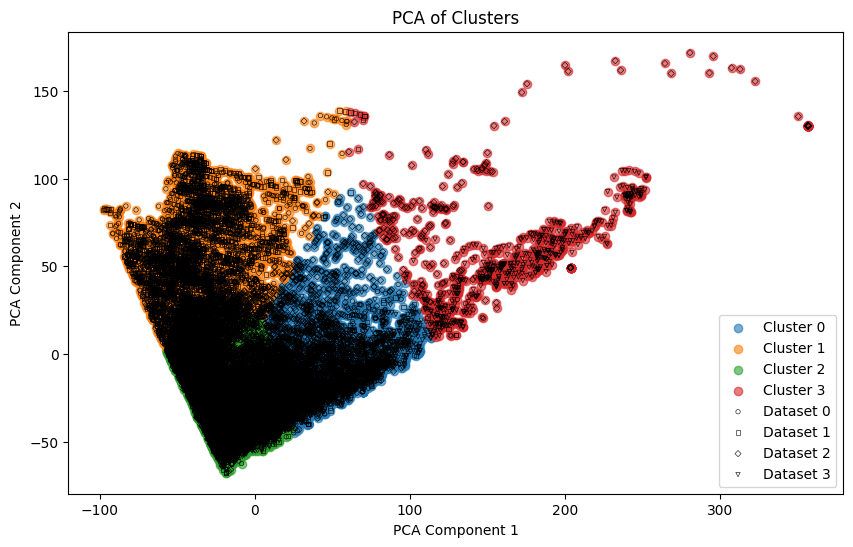

In [10]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def cluster(inputs_list, n_clusters, n_init=10, random_state=42):
    all_inputs = np.vstack(inputs_list)
    print('Clustering')
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    cluster_labels = kmeans.fit_predict(all_inputs)
    dataset_labels = np.concatenate([np.full(i.shape[0], idx) for idx, i in enumerate(inputs_list)])
    conf_matrix = confusion_matrix(dataset_labels, cluster_labels)
    cluster_purities = np.amax(conf_matrix, axis=0) / np.sum(conf_matrix, axis=0)
    total_purity = np.sum(np.amax(conf_matrix, axis=0)) / np.sum(conf_matrix)
    
    for cluster_idx in range(n_clusters):
        num_elements = np.sum(conf_matrix[:, cluster_idx])
        purity = cluster_purities[cluster_idx]
        print(f'Cluster {cluster_idx}: Purity = {purity:.4f}, Number of Elements = {num_elements}')
    
    print(f'Total Purity: {total_purity:.4f}')
    print('')
    
    return all_inputs, cluster_labels, dataset_labels
    
def plot_pca(all_inputs, cluster_labels, dataset_labels):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(all_inputs)
    plt.figure(figsize=(10, 6))
    for cluster_idx in np.unique(cluster_labels):
        plt.scatter(reduced_data[cluster_labels == cluster_idx, 0], 
                    reduced_data[cluster_labels == cluster_idx, 1], 
                    label=f'Cluster {cluster_idx}', alpha=0.6)
    
    markers = ['o', 's', 'D', 'v']  
    for dataset_idx in np.unique(dataset_labels):
        plt.scatter(reduced_data[dataset_labels == dataset_idx, 0], 
                    reduced_data[dataset_labels == dataset_idx, 1], 
                    label=f'Dataset {dataset_idx}', 
                    marker=markers[dataset_idx], 
                    edgecolor='black', 
                    facecolors='none', 
                    s=10,
                    linewidths=0.4)  
    
    plt.title('PCA of Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

C = 512
L = 96
skip = 10
i1, o1 = preprocess('/kaggle/input/electricity/ETTm1.csv', ['HUFL'], C, L, skip, True)
i2, o2 = preprocess('/kaggle/input/electricity/ETTm1.csv', ['MUFL'], C, L, skip, True)
i3, o3 = preprocess('/kaggle/input/electricity/ETTm1.csv', ['LUFL'], C, L, skip, True)
i4, o4 = preprocess('/kaggle/input/electricity/ETTm1.csv', ['OT'], C, L, skip, True)

inputs = [i1, i2, i3, i4]
cluster(inputs, 4)

outputs = [o1, o2, o3, o4]

out_real = outputs.copy()
for i in range(len(out_real)):
    out_real[i] = get_real(out_real[i])
    
cluster(out_real, 4)

out_imaginary = outputs.copy()
for i in range(len(out_imaginary)):
    out_imaginary[i] = get_imaginary(out_imaginary[i])
    
cluster(out_imaginary, 4)

out_amplitudes = outputs.copy()
for i in range(len(out_amplitudes)):
    out_amplitudes[i] = get_amplitudes(out_amplitudes[i])
    
arg1, arg2, arg3 = cluster(out_amplitudes, 4)

out_phases = outputs.copy()
for i in range(len(out_phases)):
    out_phases[i] = get_phases(out_phases[i])
    
cluster(out_phases, 4)

plot_pca(arg1, arg2, arg3)

In [7]:
import torch
import torch.nn as nn

class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: 
            raise NotImplementedError
        return x

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

In [8]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, use_revin=True):
        super(FullyConnectedNN, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units
        self.use_revin = use_revin

        if self.use_revin:
            # Add RevIN layer if use_revin is True
            self.revin = RevIN(num_features=input_size, affine=False)

        # Build the fully connected layers
        layers = []
        layers.append(nn.Linear(self.input_size, self.hidden_units))
        layers.append(nn.ReLU())
        hidden = self.hidden_units

        for _ in range(self.hidden_layers - 1):
            layers.append(nn.Linear(hidden, hidden // 2))
            layers.append(nn.ReLU())
            hidden = hidden // 2

        layers.append(nn.Linear(hidden, self.output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        # Apply RevIN normalization only if use_revin is True
        if self.use_revin:
            x = self.revin(x, mode='norm')
        
        # Pass through the model
        x = self.model(x)
        
        # Apply RevIN denormalization only if use_revin is True
        if self.use_revin:
            x = self.revin(x, mode='denorm')
        
        return x


In [9]:
class LSTMNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, use_revin=True):
        super(LSTMNN, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units
        self.use_revin = use_revin

        if self.use_revin:
            # Add RevIN layer if use_revin is True
            self.revin = RevIN(num_features=input_size, affine=False)

        # LSTM layer and fully connected layer
        self.lstm = nn.LSTM(input_size, hidden_units, hidden_layers, batch_first=True)
        self.fc = nn.Linear(hidden_units, output_size)
    
    def forward(self, x):
        # Apply RevIN normalization only if use_revin is True
        if self.use_revin:
            x = self.revin(x, mode='norm')

        if len(x.shape) == 2:  
            x = x.unsqueeze(1)

        h_0 = torch.zeros(self.hidden_layers, x.size(0), self.hidden_units).to(x.device)
        c_0 = torch.zeros(self.hidden_layers, x.size(0), self.hidden_units).to(x.device)

        lstm_out, _ = self.lstm(x, (h_0, c_0))

        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)

        # Apply RevIN denormalization only if use_revin is True
        if self.use_revin:
            out = self.revin(out, mode='denorm')

        return out


In [10]:
import torch
import torch.nn as nn

class TimeSeriesCNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, num_filters, kernel_size, use_revin=True):
        super(TimeSeriesCNN, self).__init__()
        
        self.input_size = input_size 
        self.output_size = output_size 
        self.hidden_layers = hidden_layers  
        self.hidden_units = hidden_units  
        self.num_filters = num_filters  
        self.kernel_size = kernel_size  
        self.use_revin = use_revin

        if self.use_revin:
            self.revin = RevIN(num_features=input_size, affine=False) 

        self.conv_layers = []
        self.conv_layers.append(nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size))
        self.conv_layers.append(nn.ReLU())
        
        hidden_filters = num_filters
        for _ in range(self.hidden_layers - 1):
            self.conv_layers.append(nn.Conv1d(in_channels=hidden_filters, out_channels=hidden_filters * 2, kernel_size=kernel_size))
            self.conv_layers.append(nn.ReLU())
            hidden_filters *= 2

        self.conv_layers = nn.Sequential(*self.conv_layers)

        self.fc = nn.Linear(hidden_filters, output_size)

    def forward(self, x):
        # Apply RevIN normalization if use_revin is True
        if self.use_revin:
            x = self.revin(x, mode='norm')

        x = x.unsqueeze(1) 
        x = self.conv_layers(x)

        # Global max pooling to reduce the time steps to 1
        x = torch.max(x, dim=2)[0]
        out = self.fc(x)

        # Apply RevIN denormalization if use_revin is True
        if self.use_revin:
            out = self.revin(out, mode='denorm')

        return out


In [11]:
def train_model(model, train_inputs, train_outputs, val_inputs, val_outputs, num_epochs=20, learning_rate=0.001, batch_size=32):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_inputs).float(), torch.tensor(train_outputs).float())
    val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_inputs).float(), torch.tensor(val_outputs).float())

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)

        if epoch % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


In [12]:
def predict(model, inputs):
    model.eval()
    inputs = torch.tensor(inputs).float().to(device)
    
    with torch.no_grad():  
        outputs = model(inputs)  
    outputs = outputs.cpu().numpy()
    return outputs

def predict_batch(model, inputs, batch_size=16):
    model.eval()  # Set the model to evaluation mode
    outputs_list = []  # To store outputs

    # Convert inputs to a tensor and move to the correct device
    inputs = torch.tensor(inputs).float().to(device)

    # Clear CUDA cache before inference
    torch.cuda.empty_cache()

    # Process inputs in batches
    for i in range(0, len(inputs), batch_size):
        batch = inputs[i:i + batch_size]
        with torch.no_grad():  # Disable gradient tracking
            outputs = model(batch)  # Forward pass
        outputs_list.append(outputs.cpu().numpy())  # Move outputs to CPU and convert to numpy

    # Concatenate all outputs if using batches
    return np.concatenate(outputs_list)

def measure_mse(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    return mse

In [13]:
def pipeline(model_type, fourier, use_revin = True):
    #Read and preprocess CSV files
    C = 512
    L = 96
    skip = 10
    input_data, output_data = preprocess('/kaggle/input/electricity/ETTm1.csv', ['HUFL', 'HULL', 'MUFL', 'MULL'], C, L, skip)
    test_inputs, test_outputs = preprocess('/kaggle/input/electricity/ETTm1.csv', ['LUFL', 'LULL'], C, L, skip)
    train_inputs, val_inputs, train_outputs, val_outputs = train_test_split(input_data, output_data, test_size=0.2, random_state=42)
    
    #Calculate the attribute vectors for all the train outputs
    train_outputs_attr = apply_transform(train_outputs)
    val_outputs_attr = apply_transform(val_outputs)
    test_outputs_attr = apply_transform(test_outputs)
    
    # Initialize the model
    if fourier: 
        if model_type == 'LSTM':
            model = LSTMNN(C, 2*L, 3, 128, False)
        else:
            model = FullyConnectedNN(C, 2*L, 3, 128, False)
    else:
        if model_type == 'LSTM':
            model = LSTMNN(C, L, 3, 128, use_revin)
        elif model_type == 'CNN':
            model = TimeSeriesCNN(C, L, 3, 64, 32, 7, use_revin)
        else:
            model = FullyConnectedNN(C, L, 3, 128, use_revin)
    
    # Train the model
    print("Training")
    
    if fourier:
        train_model(model, train_inputs, train_outputs_attr, val_inputs, val_outputs_attr, 50)
    else:
        train_model(model, train_inputs, train_outputs, val_inputs, val_outputs, 50)

    #Training Loss
    print('\nTraining Losses:')
    
    if model_type == 'CNN':
        train_predict = predict_batch(model, train_inputs)
        val_predict = predict_batch(model, val_inputs)
        test_predict = predict_batch(model, test_inputs)
    else:
        train_predict = predict(model, train_inputs)
        val_predict = predict(model, val_inputs)
        test_predict = predict(model, test_inputs)

    #Apply inverse DTFT on the predicted outputs to get back in time domain
    if fourier:
        train_result = apply_inverse(train_predict)
        val_result = apply_inverse(val_predict)
        test_result = apply_inverse(test_predict)
    else:
        train_result = train_predict
        val_result = val_predict
        test_result = test_predict
    
    print('\nEvalation Losses:')
    mse = measure_mse(train_result, train_outputs)
    print(f'Train MSE: {mse:.4f}')
    mse = measure_mse(val_result, val_outputs)
    print(f'Validation MSE: {mse:.4f}')
    mse = measure_mse(test_result, test_outputs)
    print(f'Test MSE: {mse:.4f}')

    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nTotal number of parameters: {total_params}")
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [35]:
pipeline('Normal', False, False)

Training
Epoch 1/50, Training Loss: 10.5477, Validation Loss: 7.9404
Epoch 6/50, Training Loss: 6.9209, Validation Loss: 6.9950
Epoch 11/50, Training Loss: 6.4599, Validation Loss: 6.7987
Epoch 16/50, Training Loss: 6.0029, Validation Loss: 6.6275
Epoch 21/50, Training Loss: 5.5743, Validation Loss: 6.8523
Epoch 26/50, Training Loss: 5.1940, Validation Loss: 6.6715
Epoch 31/50, Training Loss: 4.8383, Validation Loss: 6.3192
Epoch 36/50, Training Loss: 4.5762, Validation Loss: 6.4532
Epoch 41/50, Training Loss: 4.3397, Validation Loss: 6.2514
Epoch 46/50, Training Loss: 4.1558, Validation Loss: 5.9923

Training Losses:

Evalation Losses:
Train MSE: 3.9916
Validation MSE: 6.1362
Test MSE: 0.4032

Total number of parameters: 79168


In [16]:
pipeline('Normal', False)

Training
Epoch 1/50, Training Loss: 10.0625, Validation Loss: 7.9181
Epoch 6/50, Training Loss: 6.8006, Validation Loss: 7.1641
Epoch 11/50, Training Loss: 6.2122, Validation Loss: 6.8083
Epoch 16/50, Training Loss: 5.6909, Validation Loss: 6.8801
Epoch 21/50, Training Loss: 5.2548, Validation Loss: 6.5946
Epoch 26/50, Training Loss: 4.7834, Validation Loss: 6.5296
Epoch 31/50, Training Loss: 4.4330, Validation Loss: 6.0952
Epoch 36/50, Training Loss: 4.1443, Validation Loss: 5.9842
Epoch 41/50, Training Loss: 3.8925, Validation Loss: 5.9135
Epoch 46/50, Training Loss: 3.7616, Validation Loss: 5.7762

Training Losses:

Evalation Losses:
Train MSE: 3.5903
Validation MSE: 5.6573
Test MSE: 0.4303

Total number of parameters: 79168


In [36]:
pipeline('Normal', True)

Training
Epoch 1/50, Training Loss: 595.5246, Validation Loss: 384.5291
Epoch 6/50, Training Loss: 334.8066, Validation Loss: 342.4083
Epoch 11/50, Training Loss: 313.4100, Validation Loss: 338.2068
Epoch 16/50, Training Loss: 298.7032, Validation Loss: 320.9075
Epoch 21/50, Training Loss: 284.8604, Validation Loss: 314.2406
Epoch 31/50, Training Loss: 250.2022, Validation Loss: 315.5323
Epoch 36/50, Training Loss: 234.5886, Validation Loss: 302.6018
Epoch 41/50, Training Loss: 218.8237, Validation Loss: 302.2234
Epoch 46/50, Training Loss: 208.8695, Validation Loss: 293.4660

Training Losses:

Evalation Losses:
Train MSE: 4.0106
Validation MSE: 5.9301
Test MSE: 0.3940

Total number of parameters: 82336


In [17]:
pipeline('LSTM', False, False)

Training
Epoch 1/50, Training Loss: 24.6895, Validation Loss: 18.9190
Epoch 6/50, Training Loss: 9.7840, Validation Loss: 9.7048
Epoch 11/50, Training Loss: 9.0875, Validation Loss: 9.5867
Epoch 16/50, Training Loss: 8.5292, Validation Loss: 8.7916
Epoch 21/50, Training Loss: 8.3336, Validation Loss: 8.3082
Epoch 26/50, Training Loss: 8.0846, Validation Loss: 8.2376
Epoch 31/50, Training Loss: 7.9085, Validation Loss: 8.3966
Epoch 36/50, Training Loss: 7.7479, Validation Loss: 8.3470
Epoch 41/50, Training Loss: 7.7646, Validation Loss: 8.8037
Epoch 46/50, Training Loss: 7.7005, Validation Loss: 8.0417

Training Losses:

Evalation Losses:
Train MSE: 7.3586
Validation MSE: 8.1691
Test MSE: 0.8037

Total number of parameters: 605280


In [18]:
pipeline('LSTM', False)

Training
Epoch 1/50, Training Loss: 11.3889, Validation Loss: 8.5195
Epoch 6/50, Training Loss: 7.1308, Validation Loss: 7.6146
Epoch 11/50, Training Loss: 6.4322, Validation Loss: 7.1552
Epoch 16/50, Training Loss: 5.7901, Validation Loss: 7.2028
Epoch 21/50, Training Loss: 5.1778, Validation Loss: 6.5971
Epoch 26/50, Training Loss: 4.6721, Validation Loss: 6.5545
Epoch 31/50, Training Loss: 4.2521, Validation Loss: 6.1698
Epoch 36/50, Training Loss: 3.7909, Validation Loss: 6.2433
Epoch 41/50, Training Loss: 3.5704, Validation Loss: 5.7033
Epoch 46/50, Training Loss: 3.2718, Validation Loss: 5.4932

Training Losses:

Evalation Losses:
Train MSE: 2.9737
Validation MSE: 5.4381
Test MSE: 0.5003

Total number of parameters: 605280


In [22]:
pipeline('LSTM', True)

Training
Epoch 1/50, Training Loss: 2065.3274, Validation Loss: 1941.2909
Epoch 6/50, Training Loss: 1398.2383, Validation Loss: 1339.7988
Epoch 11/50, Training Loss: 952.4646, Validation Loss: 933.7360
Epoch 16/50, Training Loss: 626.2232, Validation Loss: 613.3162
Epoch 21/50, Training Loss: 488.8479, Validation Loss: 481.1502
Epoch 26/50, Training Loss: 452.2016, Validation Loss: 455.7740
Epoch 31/50, Training Loss: 425.2674, Validation Loss: 441.8663
Epoch 36/50, Training Loss: 408.7770, Validation Loss: 425.9783
Epoch 41/50, Training Loss: 392.9360, Validation Loss: 421.9610
Epoch 46/50, Training Loss: 387.7484, Validation Loss: 403.4065

Training Losses:

Evalation Losses:
Train MSE: 7.9676
Validation MSE: 8.4684
Test MSE: 0.8357

Total number of parameters: 617664


In [48]:
pipeline('CNN', False, False)

Training
Epoch 1/50, Training Loss: 23.9481, Validation Loss: 24.1317
Epoch 6/50, Training Loss: 21.4453, Validation Loss: 21.5333
Epoch 11/50, Training Loss: 20.8696, Validation Loss: 20.7952
Epoch 16/50, Training Loss: 20.5866, Validation Loss: 20.6206
Epoch 21/50, Training Loss: 20.3877, Validation Loss: 20.6957
Epoch 26/50, Training Loss: 20.2326, Validation Loss: 20.6507
Epoch 31/50, Training Loss: 20.1074, Validation Loss: 20.7594
Epoch 36/50, Training Loss: 20.0318, Validation Loss: 20.9955
Epoch 41/50, Training Loss: 19.8966, Validation Loss: 21.0719
Epoch 46/50, Training Loss: 19.7730, Validation Loss: 21.1088

Training Losses:

Evalation Losses:
Train MSE: 19.3991
Validation MSE: 21.0776
Test MSE: 1.5272

Total number of parameters: 84512


In [49]:
pipeline('CNN', False)

Training
Epoch 1/50, Training Loss: 23.3232, Validation Loss: 22.7037
Epoch 6/50, Training Loss: 21.4987, Validation Loss: 21.2477
Epoch 11/50, Training Loss: 20.8685, Validation Loss: 20.9520
Epoch 16/50, Training Loss: 20.5628, Validation Loss: 20.6802
Epoch 21/50, Training Loss: 20.3716, Validation Loss: 20.6929
Epoch 26/50, Training Loss: 20.2048, Validation Loss: 20.6999
Epoch 31/50, Training Loss: 20.0684, Validation Loss: 20.5927
Epoch 36/50, Training Loss: 19.9323, Validation Loss: 20.7919
Epoch 41/50, Training Loss: 19.8172, Validation Loss: 20.8221
Epoch 46/50, Training Loss: 19.6707, Validation Loss: 21.0188

Training Losses:

Evalation Losses:
Train MSE: 19.2931
Validation MSE: 20.8215
Test MSE: 0.6569

Total number of parameters: 84512


In [14]:
from sklearn.decomposition import PCA

#Represent data in terms of their k principal components (deformable parameters)

def apply_pca(outputs, k):
    pca = PCA(n_components=k)
    transformed_data = pca.fit_transform(outputs)
    return pca, transformed_data

#Reconstruct the original data from the deformable parameters

def reconstruct_data(pca, transformed_data, k):
    principal_components = pca.components_[:k]
    reconstructed_data = np.dot(transformed_data, principal_components)
    mean = pca.mean_
    reconstructed_data += mean
    return reconstructed_data

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
    
C = 512
L = 96
#PCA length
K = 6
skip = 10

input_data, output_data = preprocess('/kaggle/input/electricity/ETTm1.csv', ['HUFL', 'HULL', 'MUFL', 'MULL'], C, L, skip)
test_inputs, test_outputs = preprocess('/kaggle/input/electricity/ETTm1.csv', ['LUFL', 'LULL'], C, L, skip)

#Conditions for a task are the fourier coefficients of the past data
test_cond = apply_transform(test_inputs)
input_cond = apply_transform(input_data)

#Output of a task is the pca representation of the future data
pca, output_shape = apply_pca(output_data, K)

#Split everything into train and validation
train_ind, val_ind = train_test_split(range(0, len(input_data)), test_size = 0.2, random_state = 42)
train_input = input_data[train_ind]
val_input = input_data[val_ind]
train_output = output_data[train_ind]
val_output = output_data[val_ind]

train_cond = input_cond[train_ind]
val_cond = input_cond[val_ind]
train_shape = output_shape[train_ind]
val_shape = output_shape[val_ind]

#Choose model
if False:
    model = FullyConnectedNN(2*C, K, 3, 128, False)
    print("NN")
else:
    model = LSTMNN(2*C, K, 3, 128, False)
    print("LSTM")
    
train_model(model, train_cond, train_shape, val_cond, val_shape, 50)

#Get the deformable parameters (pca representation) of from the conditions
train_predict = predict(model, train_cond)
val_predict = predict(model, val_cond)
test_predict = predict(model, test_cond)

#Reconstruct the original data
train_result = reconstruct_data(pca, train_predict, K)
val_result = reconstruct_data(pca, val_predict, K)
test_result = reconstruct_data(pca, test_predict, K)

print('\nEvalation Losses:')
mse = measure_mse(train_result, train_output)
print(f'Train MSE: {mse:.4f}')
mse = measure_mse(val_result, val_output)
print(f'Validation MSE: {mse:.4f}')
mse = measure_mse(test_result, test_outputs)
print(f'Test MSE: {mse:.4f}')




Using device: cuda
LSTM
Epoch 1/50, Training Loss: 331.5163, Validation Loss: 260.2329
Epoch 6/50, Training Loss: 184.3299, Validation Loss: 192.3646
Epoch 11/50, Training Loss: 166.7301, Validation Loss: 180.4595
Epoch 16/50, Training Loss: 157.4668, Validation Loss: 173.9390
Epoch 21/50, Training Loss: 149.7729, Validation Loss: 170.6932
Epoch 26/50, Training Loss: 144.7813, Validation Loss: 170.0257
Epoch 31/50, Training Loss: 138.7953, Validation Loss: 164.7194
Epoch 36/50, Training Loss: 133.5479, Validation Loss: 159.5951
Epoch 41/50, Training Loss: 128.3286, Validation Loss: 161.2673
Epoch 46/50, Training Loss: 124.7847, Validation Loss: 159.8946

Evalation Losses:
Train MSE: 8.7848
Validation MSE: 11.2396
Test MSE: 22.9087
